In [1]:
#Import necessary libraries
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from IPython.display import Image
from pgmpy.inference import VariableElimination
import warnings
warnings.filterwarnings('ignore')

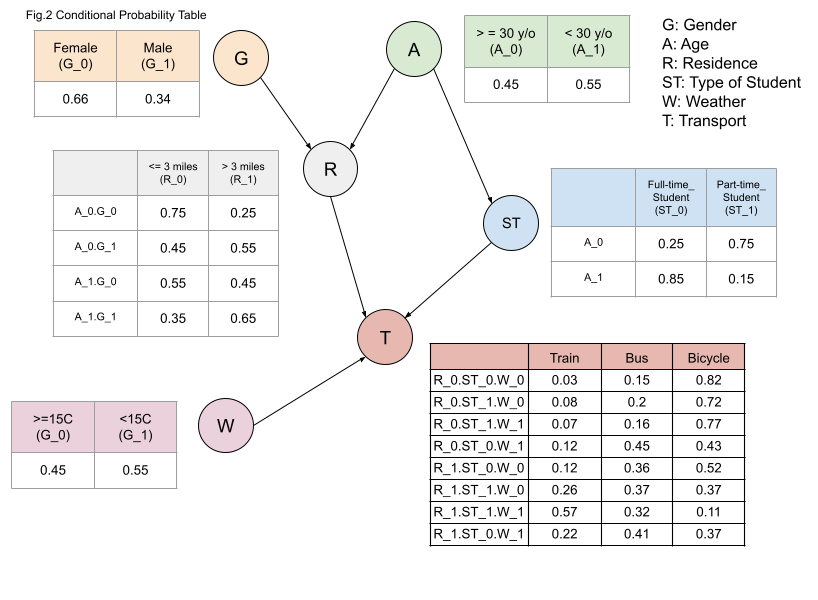

In [2]:
#Showing the Directed Acyclic graphical model as reference. Figure 2 also shows the 
#Conditional Probability Distributions (CPD) which will be used as parameters for the BN.
#Probabilities estimates are explained in the main report
Image('/Users/marinap/Data_Science/AI/CPT_DSM100.png')

In [3]:
#Step 1: Declare a BN with the nodes from the above DAG
transport_DSS = BayesianNetwork([('Gender', 'Residence'),
                              ('Age', 'Residence'),
                              ('Age', 'Student Type'),
                              ('Residence', 'Transport'),
                              ('Student Type', 'Transport'),
                              ('Weather', 'Transport')
                              ])

Step 2: Defining individual Conditional Probability Distributions (CPDs) for each node in the BN: Gender, Age, Residence, Student Type, Weather and Transport

In [4]:
#According to Goldsmiths' Diversity Report, 66% of students identified as Female
Gender_cpd = TabularCPD(
    variable = 'Gender',
    variable_card = 2,   # cardinality
    values = [[.66], #Female
              [.34]], #Male
    #CPDs can be defined using the state names of the variables.
    state_names={'Gender':['Female','Male']})   # ['Female', 'Male']

In [5]:
#Assumes that foreign students at Goldsmiths tend to be postgraduates skewing slightly younger than 30 y/o
Age_cpd = TabularCPD(
    variable = 'Age',
    variable_card = 2,   # cardinality
    values = [[.45], #'Above or 30 y/o'
              [.55]], #'Below 30 y/o'
    state_names={'Age':['>=30','<30']})   # ['Above or 30 y/o', 'Below 30 y/o']

In [6]:
#Assumes female students will prefer to live closer from campus for safety reasons
Residence_cpd = TabularCPD(
    variable = 'Residence',
    variable_card = 2,
    values = [[.75, .45, .55, .35], #Within 3 miles
              [.25, .55, .45, .65]], #Beyond 3 miles
    evidence = ['Gender', 'Age'],
    evidence_card = [2,2],
    state_names={'Residence': ['>=3_Miles','<3_Miles'], #states of the variable
                 'Gender':['Female','Male'],
                 'Age':['>=30','<30']})

In [7]:
#Assumes that average temperature in London during academic months is 14.5C
#Source: https://www.google.com/search?q=london+average+temperature+by+month&oq=london+ave&aqs=chrome.4.0i512j69i57j0i512j0i433i457i512j0i512l2j69i64l2.10923j1j4&sourceid=chrome&ie=UTF-8
Weather_cpd = TabularCPD(
    variable = 'Weather',
    variable_card = 2,   # cardinality
    values = [[.45], #'Above or 15C'
              [.55]], #'Below 15C'
    state_names={'Weather':['>=15C','<15C']})   # ['Above or 15C', 'Below 15C']

In [8]:
#Assumes most foreign students above or 30 y/o are part-time and most below 30 y/o are full-time 
Student_Type_cpd=TabularCPD(
    variable = 'Student Type',
    variable_card = 2,   #cardinality
    values = [[.35,.75],  #['full-time']
              [.65,.25]], #['part-time']
    evidence = ['Age'], #Variable dependency declared
    evidence_card = [2],
    state_names={'Student Type': ['Full_Time', 'Part_Time'], #states of the variable
                 'Age':['>=30','<30']})

In [9]:
#Assumes that students who live less than 3 miles from campus would prioritize bicycle and bus,
#students who live further away would also prefer the train
transport_cpd=TabularCPD(
    variable = 'Transport',
    variable_card = 3,   # cardinality
    values = [[0.03,0.08,0.07,0.12,0.12,0.26,0.57,0.22],# ['Train']
              [0.15,0.2,0.16,0.45,0.36,0.37,0.32,0.41], #['Bus']
              [0.82,0.72,0.77,0.43,0.52,0.37,0.11,0.37]],#['Bicycle']
    evidence = ['Residence', 'Student Type', 'Weather'],
    evidence_card = [2,2,2],
    state_names={'Transport':['Train','Bus', 'Bicycle'],
                 'Residence': ['>=3_Miles','<3_Miles'],
                 'Student Type': ['Full_Time', 'Part_Time'],
                 'Weather': ['>=15C','<15C']
    })

In [10]:
#Add all cpds to the Bayesian Network
transport_DSS.add_cpds(Gender_cpd, Age_cpd, Residence_cpd, Weather_cpd, Student_Type_cpd, transport_cpd)

In [11]:
## check for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1
transport_DSS.check_model()

True

In [12]:
# Call get_cpd method on the BayesianModel object for all variables
transport_DSS.get_cpds()

[<TabularCPD representing P(Gender:2) at 0x7fb238d05f50>,
 <TabularCPD representing P(Age:2) at 0x7fb238d19750>,
 <TabularCPD representing P(Residence:2 | Gender:2, Age:2) at 0x7fb238d1e7d0>,
 <TabularCPD representing P(Weather:2) at 0x7fb238d1eb90>,
 <TabularCPD representing P(Student Type:2 | Age:2) at 0x7fb238d05750>,
 <TabularCPD representing P(Transport:3 | Residence:2, Student Type:2, Weather:2) at 0x7fb238d1eed0>]

In [13]:
#Now call function for a specific variable, Transport
print(transport_DSS.get_cpds('Transport'))

+--------------------+-----+-------------------------+
| Residence          | ... | Residence(<3_Miles)     |
+--------------------+-----+-------------------------+
| Student Type       | ... | Student Type(Part_Time) |
+--------------------+-----+-------------------------+
| Weather            | ... | Weather(<15C)           |
+--------------------+-----+-------------------------+
| Transport(Train)   | ... | 0.22                    |
+--------------------+-----+-------------------------+
| Transport(Bus)     | ... | 0.41                    |
+--------------------+-----+-------------------------+
| Transport(Bicycle) | ... | 0.37                    |
+--------------------+-----+-------------------------+


In [14]:
#Print trail nodes to get to Age variable
transport_DSS.active_trail_nodes('Age')

{'Age': {'Age', 'Residence', 'Student Type', 'Transport'}}

In [15]:
# Getting the local independencies of variable.
transport_DSS.get_independencies()

(Gender ⟂ Weather, Student Type, Age)
(Gender ⟂ Weather, Student Type | Age)
(Gender ⟂ Student Type, Age | Weather)
(Gender ⟂ Weather | Residence)
(Gender ⟂ Weather, Age | Student Type)
(Gender ⟂ Student Type | Weather, Age)
(Gender ⟂ Weather, Student Type, Transport | Residence, Age)
(Gender ⟂ Weather | Student Type, Age)
(Gender ⟂ Age | Weather, Student Type)
(Gender ⟂ Weather, Transport | Student Type, Residence)
(Gender ⟂ Student Type, Transport | Weather, Residence, Age)
(Gender ⟂ Weather, Transport | Student Type, Residence, Age)
(Gender ⟂ Weather, Student Type | Residence, Transport, Age)
(Gender ⟂ Transport | Weather, Residence, Student Type)
(Gender ⟂ Weather | Student Type, Residence, Transport)
(Gender ⟂ Transport | Weather, Residence, Student Type, Age)
(Gender ⟂ Student Type | Weather, Residence, Transport, Age)
(Gender ⟂ Weather | Student Type, Residence, Transport, Age)
(Weather ⟂ Gender, Student Type, Residence, Age)
(Weather ⟂ Student Type, Residence, Age | Gender)
(We

From analyzing local independencies, we can observe that:
- The probability of transport being Train is increased since it requires the probability of Gender being Female, Age being above 30, residence is more than 3 miles from campus, is a part-time student and the weather is below 15C. The probability formula for this path would be:

P(G, A, R, ST, W, T) = P(T | W,ST,R,A,G)^P(ST | R,A,G)^P(R | A,G)^P(W)^P(A)^P(G)

Now let's test this assumption

In [16]:
#Declare the variable eliminitation method on the created BN
transport_infer = VariableElimination(transport_DSS)

In [17]:
#Print how likely is to get a mode of transport without specifying any condition
prob_response = transport_infer.query(variables = ['Transport'], joint=False, show_progress=False)
print(prob_response['Transport'])

+--------------------+------------------+
| Transport          |   phi(Transport) |
+====================+==================+
| Transport(Train)   |           0.1638 |
+--------------------+------------------+
| Transport(Bus)     |           0.3019 |
+--------------------+------------------+
| Transport(Bicycle) |           0.5342 |
+--------------------+------------------+


In [18]:
#Print prediction for a generic path
print(transport_cpd)

+--------------------+-----+-------------------------+
| Residence          | ... | Residence(<3_Miles)     |
+--------------------+-----+-------------------------+
| Student Type       | ... | Student Type(Part_Time) |
+--------------------+-----+-------------------------+
| Weather            | ... | Weather(<15C)           |
+--------------------+-----+-------------------------+
| Transport(Train)   | ... | 0.22                    |
+--------------------+-----+-------------------------+
| Transport(Bus)     | ... | 0.41                    |
+--------------------+-----+-------------------------+
| Transport(Bicycle) | ... | 0.37                    |
+--------------------+-----+-------------------------+


In [19]:
prob_part_time = transport_infer.query(variables = ['Student Type'], joint=False, show_progress=False)
print(prob_part_time['Student Type'])

+-------------------------+---------------------+
| Student Type            |   phi(Student Type) |
+=========================+=====================+
| Student Type(Full_Time) |              0.5700 |
+-------------------------+---------------------+
| Student Type(Part_Time) |              0.4300 |
+-------------------------+---------------------+


<h3>Type of query: Prediction - focused around inferring outputs from inputs.</h3>
<b>Question 1):</b> what is the preferred transport method for a Female, part-time, above 30 years old student when the weather is below 15C?

In [20]:
evidence = {'Gender':0, 'Age':0, 'Student Type':1, 'Weather':1}
result = transport_infer.query(variables=['Transport'],
                          joint=False, show_progress=False,
                          evidence=evidence)
print(result['Transport'])

+--------------------+------------------+
| Transport          |   phi(Transport) |
+====================+==================+
| Transport(Train)   |           0.1450 |
+--------------------+------------------+
| Transport(Bus)     |           0.4400 |
+--------------------+------------------+
| Transport(Bicycle) |           0.4150 |
+--------------------+------------------+


The recommended mode of transport is Bus with a probability of **44%**

<b>Question 2):</b> what is the preferred transport method for a Male student, who is above 30 years old and lives within 3 miles when the weather is above 15C?

In [21]:
evidence = {'Gender':1, 'Age':0, 'Residence':0, 'Weather':0}
result = transport_infer.query(variables=['Transport'],
                          joint=False, show_progress=False,
                          evidence=evidence)
print(result['Transport'])

+--------------------+------------------+
| Transport          |   phi(Transport) |
+====================+==================+
| Transport(Train)   |           0.0560 |
+--------------------+------------------+
| Transport(Bus)     |           0.1565 |
+--------------------+------------------+
| Transport(Bicycle) |           0.7875 |
+--------------------+------------------+


The recommended mode of transport is Bicycle with a probability of **78%**

<h3>Type of query: Diagnostics - inferring inputs from outputs</h3>
<b>Question 3):</b> What type of student would prefer to travel by train when the weather is below 15C who is above 30 years old?

In [22]:
evidence = {'Age':0, 'Transport':0, 'Weather':1}
result = transport_infer.query(variables=['Student Type'],
                          joint=False, show_progress=False,
                          evidence=evidence)
print(result['Student Type'])

+-------------------------+---------------------+
| Student Type            |   phi(Student Type) |
+=========================+=====================+
| Student Type(Full_Time) |              0.3274 |
+-------------------------+---------------------+
| Student Type(Part_Time) |              0.6726 |
+-------------------------+---------------------+


The answer is that the student who is above 30 years old who uses the train on a cold day, has a 67% probability of being a part time student.